## Определение перспективного тарифа для телеком компании "Мегалайн"

Заказчик исследования — федеральный оператор сотовой связи «Мегалайн». Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег**.

Мы проведём предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Мы проанализируем поведение клиентов и сделать вывод — какой тариф лучше.

Исследование будет состоять из нескольких этапов: внешнее знакомство с данными, предобработка данных, исследовательский и статистических анализ датасета. В завершение мы сформулируем гипотезы о различии средних выручек с клиентов разных тарифов и о разнице в выручке с жителей Москвы и остальных регионов.

## Содержание
1. [Знакомство с данными](#1)
2. [Подготовка данных для анализа](#2) <br>
2.1 [Количество сделанных звонков и израсходованных минут разговора по месяцам](#2.1) <br>
2.2 [Количество отправленных сообщений по месяцам](#2.2) <br>
2.3 [Объем израсходованного интернет-трафика по месяцам](#2.3) <br>
2.4 [Помесячная выручка с каждого пользователя](#2.4) <br>
2.5 [Вывод](#2.5)
3. [Анализ данных](#3) <br>
    3.1. [Сколько минут требуется абонентам](#3.1) <br>
    3.2. [Какой объём интернет-трафика нужен абонентам](#3.2) <br>
    3.3. [Сколько сообщений отправляют абоненты](#3.3) <br>
    3.4. [Зависимость нужд абонентов в зависимости от месяца](#3.4) <br>
    3.5 [Среднее количество, дисперсия и стандартное отклонение](#3.5) <br>
    3.5. [Вывод](#3.6)
4. [Проверка гипотез](#4)
5. [Общий вывод](#5)

<a id="1"></a>
### 1. Знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st


calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")

В нашем распоряжении есть 5 датасетов, которые содержат таблицы с информацией о пользователях, информацией о тарифах, о том, как абоненты расходуют пакеты звонков, СМС и интернета.<br>
На этапе подготовки данных к анализу нам предстоит очистить эти данные от пропусков, заменить плавающие значения целочисленными там, где это необходимо. <br>
Дата во всех сетах отражается как объект, нам нужно будет применить формат даты.<br>
В сете с данными об интернет-сеансах в одном столбце продублированы индексы - от этого столбца мы избавимся.<br>
В итоге мы объединим несколько датасетов в один.

In [2]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [3]:
calls.info()
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [4]:
internet.info()
internet.head(20)
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


В датафрейме internet видим лишний столбец "Unnamed: 0", который повторяет индексы. Избавимся от него на этапе предобработки

In [5]:
messages.info()
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [6]:
tariffs
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<a id="2"></a>
### 2. Подготовка данных к анализу

In [8]:
dfs = [calls, messages, internet, users]
 
for df in dfs:
    date_cols = [col for col in df.columns if 'date' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [10]:
# округлим данные по длительности звонков и количеству использованных мегабайт
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

# удалим столбец 'Unnamed: 0' в датафрейме internet
internet.drop(['Unnamed: 0'], axis=1)
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113,2018-11-25,1000
1,1,1000_1,1053,2018-09-07,1000
2,2,1000_2,1198,2018-06-25,1000
3,3,1000_3,551,2018-08-22,1000
4,4,1000_4,303,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,319,2018-10-03,1499
149392,149392,1499_153,491,2018-12-14,1499
149393,149393,1499_154,0,2018-10-27,1499
149394,149394,1499_155,1247,2018-11-26,1499


In [11]:
#создадим столбец с месяцем там, где это необходимо
calls['month'] = calls.set_index('call_date').index.month
messages['month'] = messages.set_index('message_date').index.month
internet['month'] = internet.set_index('session_date').index.month

Для целей нашего исследования нет необходимости учитывать звонки, продолжительность которых составляла 0 минут, поэтому удалим их из таблицы calls

In [12]:
calls = calls[calls.duration > 0]

internet = internet[internet.mb_used > 0]

<a id="2.1"></a>
### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [13]:
calls_total = calls.groupby(['user_id', 'month'])[['duration']].agg(['sum', 'count']).reset_index()
calls_total.columns = ['user_id', 'month', 'mins_total', 'calls_total']
calls_total

,user_id,month,mins_total,calls_total
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46
...,...,...,...,...
3163,1498,10,247,30
3164,1499,9,70,8
3165,1499,10,449,44
3166,1499,11,612,62


<a id="2.2"></a>
### Количество отправленных сообщений по месяцам

In [14]:
messages_total = messages.groupby(['user_id', 'month'])[['id']].agg(['count']).reset_index()
messages_total.columns = ['user_id', 'month', 'messages_total']
messages_total

,user_id,month,messages_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


<a id="2.3"></a>
### Объем израсходованного интернет-трафика по месяцам

In [15]:
internet_total = internet.groupby(['user_id', 'month'])[['mb_used']].agg(['sum']).reset_index()
internet_total.columns = ['user_id', 'month', 'internet_total']
internet_total

,user_id,month,internet_total
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3196,1498,10,20604
3197,1499,9,1848
3198,1499,10,17809
3199,1499,11,17984


<a id="2.4"></a>
### Помесячная выручка с каждого пользователя 
#### (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [16]:
internet_users = users.merge(internet_total, on='user_id', how='outer')

In [17]:
int_calls_users = internet_users.merge(calls_total, how='outer', on=['month','user_id'])
int_calls_users_mes = int_calls_users.merge(messages_total, how='outer', on=['month','user_id'])
int_calls_users_mes = int_calls_users_mes.rename(columns={'tariff': 'tariff_name'})
df = int_calls_users_mes.merge(tariffs, how='left', on=['tariff_name'])
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,month,internet_total,mins_total,calls_total,messages_total,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,2256.0,159.0,17.0,22.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23257.0,172.0,28.0,60.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14016.0,340.0,41.0,75.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14070.0,408.0,42.0,81.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,14581.0,466.0,46.0,57.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0


In [18]:
#Заменим нулями отсутствующие значения там, где это необходимо
df['messages_total'] = df.messages_total.fillna(0).astype(int)
df['mins_total'] = df.mins_total.fillna(0).astype(int)
df['calls_total'] = df.calls_total.fillna(0).astype(int)
df['internet_total'] = df.internet_total.fillna(0).astype(int)
# избавимся от отсутствующих значений там, где это необходимо
df.dropna(subset = ['tariff_name'], inplace=True)
df.dropna(subset = ['month'], inplace=True)

#заменим плавающие значения целочисленными там, где это необходимо
df['messages_included'] = df.messages_included.astype(int)
df['mb_per_month_included'] = df.mb_per_month_included.astype(int)
df['minutes_included'] = df.minutes_included.astype(int)
df['rub_monthly_fee'] = df.rub_monthly_fee.astype(int)
df['rub_per_gb'] = df.rub_per_gb.astype(int)
df['rub_per_message'] = df.rub_per_message.astype(int)
df['rub_per_minute'] = df.rub_per_minute.astype(int)
df['month'] = df.month.astype(int)
df['age'] = df.age.astype(int)
df['rub_per_mb'] = df['rub_per_gb'] / 1024

Посмотрим на результат нашей работы с пропусками

In [19]:
pd.concat([df.isna().sum().to_frame(name='Количество пропущенных значений'),
           (df.isna().sum() / len(df)).to_frame(name='Доля пропущенных значений').round(2)],axis=1).sort_values(by='Количество пропущенных значений',ascending=False)

,Количество пропущенных значений,Доля пропущенных значений
churn_date,3015,0.94
user_id,0,0.00
calls_total,0,0.00
rub_per_minute,0,0.00
rub_per_message,0,0.00
rub_per_gb,0,0.00
rub_monthly_fee,0,0.00
minutes_included,0,0.00
mb_per_month_included,0,0.00
messages_included,0,0.00


In [20]:
calls = calls[calls.duration > 0]

internet = internet[internet.mb_used > 0]

In [21]:
# сделаем так, чтобы было видно все колонки
pd.options.display.max_columns = None

В будущем нам понадобится рассчитать, какой тариф выгоднее для компании. Для этого нам понадобится знать, какую выручку принёс каждый пользователь в выборке.

In [22]:
# напишем функцию для расчёта месячной стоимости услуг оператора

def final_cost(df):
    # объявим переменные
    mins = df['mins_total']
    messages = df['messages_total']
    mb_used = df['internet_total']
    tariff = df['tariff_name']
    minutes_lim = df['minutes_included']
    mess_lim = df['messages_included']
    inter_lim = df['mb_per_month_included']
    rub_per_message = df['rub_per_message']
    rub_per_mb = df['rub_per_mb']
    rub_monthly_fee = df['rub_monthly_fee']
    rub_per_minute = df['rub_per_minute']
   
    # вычисляем переплату по звонкам. обратите внимание на первую строчку и попробуйте ее осмыслить  :) 
    call_overlimit = max(mins - minutes_lim, 0)
    internet_overlimit = max(mb_used - inter_lim, 0)
    sms_overlimit = max(messages - mess_lim, 0)
 
    # возвращаем стоимость пользованием услуг за месяц
    return rub_monthly_fee + call_overlimit * rub_per_minute + sms_overlimit * rub_per_message + internet_overlimit * rub_per_mb

df['final_cost'] = df.apply(final_cost, axis=1)
df['final_cost'] = df['final_cost'].astype(int)

<a id="2.5"></a>
### Вывод

Мы подготовили данные к анализу. Все даты теперь имеют необходимый формат. Значения минут и мегабайт мы округлили в большую сторону - так работает наш оператор.

Мы также удалили ненужные для исследования столбцы, добавили столбец с месяцем совершения той или иной операции. Мы избавились от нулевых значений в продолжительности звонков и использованных мегабайтах - для нашего исследования эти данные не интересны.

Мы также посчитали следующие параметры: 
* Количество сделанных звонков и израсходованных минут разговора по месяцам

* Количество отправленных сообщений по месяцам

* Объем израсходованного интернет-трафика по месяцам

* Помесячная выручка с каждого пользователя

Все нужные датасеты объединены в одну таблицу. Теперь данные готовы к анализу.


<a id="3"></a>
### 3. Анализ данных

#### Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

<a id="3.1"></a>
#### Сколько минут требуется абонентам

Сколько минут нужно пользователю тарифа SMART в месяц (медиана): 440
Сколько минут нужно пользователю тарифа ULTRA в месяц (медиана): 537


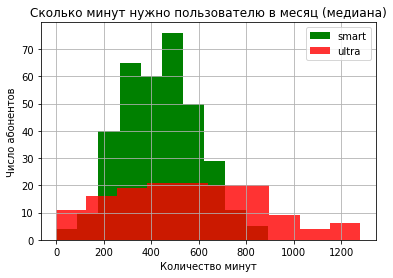

In [40]:
df1 = df.pivot_table(['mins_total','internet_total','messages_total','calls_total'],\
                 'user_id','tariff_name',aggfunc=[np.mean, np.median])
legend = ['smart', 'ultra']
df1['median']['mins_total']['smart'].hist(bins=10, color='g')
df1['median']['mins_total']['ultra'].hist(bins=10, color='r', alpha=0.8)
plt.xlabel('Количество минут')
plt.ylabel('Число абонентов')
plt.title('Сколько минут нужно пользователю в месяц (медиана)')
plt.legend(legend)

print('Сколько минут нужно пользователю тарифа SMART в месяц (медиана):', round(df1['median']['mins_total']['smart'].median()))
print('Сколько минут нужно пользователю тарифа ULTRA в месяц (медиана):', round(df1['median']['mins_total']['ultra'].median()))

Медианный пользователь тарифа smart нуждается в меньшем количестве минут, чем медианный абонент ultra. Разница составляет 97 минут. Стоит отметить, что ни в одном из тарифов пользователи не выходят за рамки заложенного в тарифе пакета минут. Пользователи smart близки к тому, чтобы израсходовать весь стандартный пакет минут.

<a id="3.2"></a>
#### Сколько мегабайт требуется абонентам

Сколько мегабайт нужно пользователю тарифа SMART в месяц (медиана): 16985
Сколько мегабайт нужно пользователю тарифа ULTRA в месяц (медиана): 19826


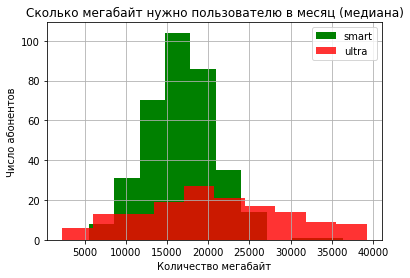

In [24]:
df1['median']['internet_total']['smart'].hist(color='g')
df1['median']['internet_total']['ultra'].hist(color='r', alpha=0.8)
plt.xlabel('Количество мегабайт')
plt.ylabel('Число абонентов')
plt.title('Сколько мегабайт нужно пользователю в месяц (медиана)')
plt.legend(legend)

print('Сколько мегабайт нужно пользователю тарифа SMART в месяц (медиана):', round(df1['median']['internet_total']['smart'].median()))
print('Сколько мегабайт нужно пользователю тарифа ULTRA в месяц (медиана):', round(df1['median']['internet_total']['ultra'].median()))

Ожидаемо, пользователи тарифа SMART потребляют меньше интернета, чем абоненты ULTRA - разница составляет 3 Гб. Также мы видим, что среди пользователей тарифа ultra заметно больше тех, кому нужно больше, чем 27 Гб трафика - среди абонентов smart таких почти нет.
Важный вывод: пользователи тарифа smart обычно выходят за рамки предложенного пакета трафика (15 Гб) и платят за интернет дополнительно. Абоненты ultra в основном укладываются в предложенный пакет 30 Гб.

<a id="3.3"></a>
#### Сколько сообщений необходимо абонентам

Сколько сообщений отправляют пользователи тарифа SMART в месяц (медиана): 28
Сколько сообщений отправляют пользователи тарифа ULTRA в месяц (медиана): 48


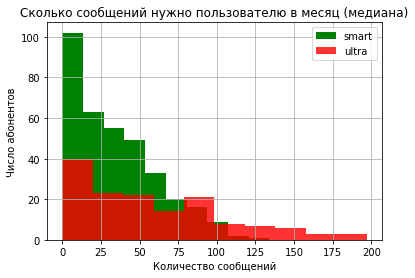

In [25]:
df1['median']['messages_total']['smart'].hist(color='g')
df1['median']['messages_total']['ultra'].hist(color='r', alpha=0.8)
plt.xlabel('Количество сообщений')
plt.ylabel('Число абонентов')
plt.title('Сколько сообщений нужно пользователю в месяц (медиана)')
plt.legend(legend)


print('Сколько сообщений отправляют пользователи тарифа SMART в месяц (медиана):', round(df1['median']['messages_total']['smart'].median()))
print('Сколько сообщений отправляют пользователи тарифа ULTRA в месяц (медиана):', round(df1['median']['messages_total']['ultra'].median()))

Пользователи обоих тарифов не проявляют интереса к общению через СМС. Абоненты smart используют чуть больше половины из предложенного пакета сообщений, а абоненты ultra не используют и пяти процентов из пакета.

<a id="3.4"></a>
Посчитаем также, **как отличаются нужды наших абонентов в зависимости от месяца**

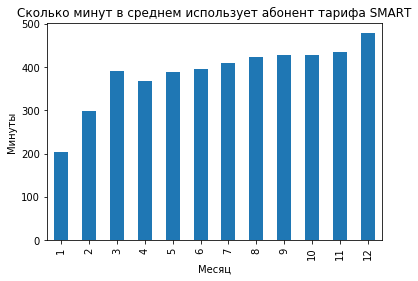

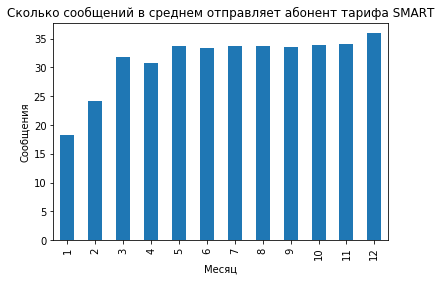

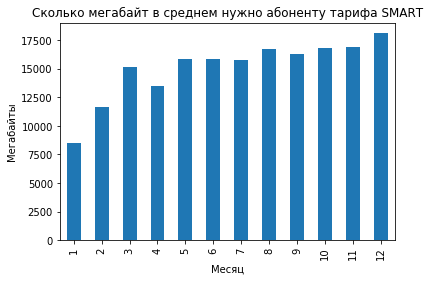

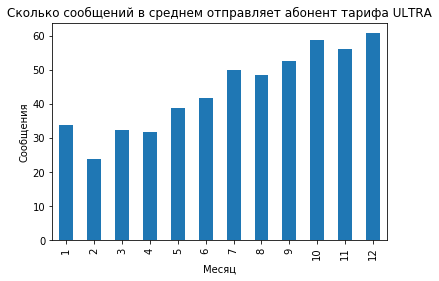

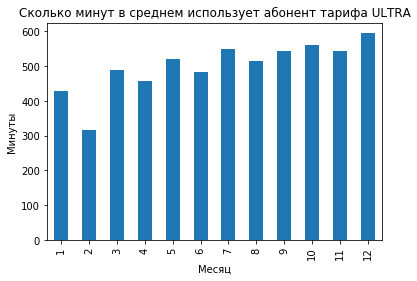

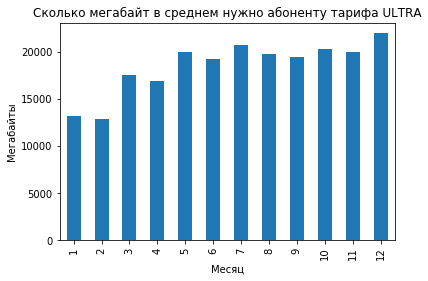

In [26]:
df.query('tariff_name == "smart"').groupby(by='month')['mins_total'].mean().plot(title='Сколько минут в среднем использует абонент тарифа SMART', kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Минуты')
plt.show()

df.query('tariff_name == "smart"').groupby(by='month')['messages_total'].mean().plot(title='Сколько сообщений в среднем отправляет абонент тарифа SMART', kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Сообщения')
plt.show()

df.query('tariff_name == "smart"').groupby(by='month')['internet_total'].mean().plot(title='Сколько мегабайт в среднем нужно абоненту тарифа SMART', kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Мегабайты')
plt.show()

df.query('tariff_name == "ultra"').groupby(by='month')['messages_total'].mean().plot(title='Сколько сообщений в среднем отправляет абонент тарифа ULTRA', kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Сообщения')
plt.show()

df.query('tariff_name == "ultra"').groupby(by='month')['mins_total'].mean().plot(title='Сколько минут в среднем использует абонент тарифа ULTRA', kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Минуты')
plt.show()

df.query('tariff_name == "ultra"').groupby(by='month')['internet_total'].mean().plot(title='Сколько мегабайт в среднем нужно абоненту тарифа ULTRA', kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Мегабайты')
plt.show()

Почти на всех графиках мы видим, что с каждым месяцем показатели увеличиваются. Это странно, потому что вряд ли в действительности абоненты меньше пользуются интернетом или звонят в феврале, чем в августе или любом другом месяце. Посмотрим, не связано ли это с тем, что число пользователей менялось с каждым месяцем.

In [27]:
df.groupby('month')['user_id'].count()

month
1      43
2      80
3     114
4     167
5     206
6     247
7     291
8     340
9     374
10    415
11    449
12    475
Name: user_id, dtype: int64

Действительно, число пользователей росло с каждым месяцем. Меньшая активность пользователей на графиках за начало года может быть связана с тем, что выборка в первые месяцы менее репрезентативна, чем в более поздние месяцы.

Посчитаем, какую месячную выручку в среднем приносит каждый пользователь интересующих нас тарифов

In [28]:
print('Пользователь тарифа SMART в среднем тратит {:.0f} рублей'.format(df.loc[df['tariff_name'] == 'smart', 'final_cost'].mean()))
print('Пользователь тарифа ULTRA в среднем тратит {:.0f} рублей'.format(df.loc[df['tariff_name'] == 'ultra', 'final_cost'].mean()))


Пользователь тарифа SMART в среднем тратит 1234 рублей
Пользователь тарифа ULTRA в среднем тратит 2062 рублей


<a id="3.5"></a>
#### Среднее количество, дисперсия и стандартное отклонение

In [29]:
var_std_mins = df.groupby(['tariff_name']).agg({'mins_total' : ['mean', lambda x: np.var(x, ddof=1), \
lambda x: np.std(x, ddof=1)]}).reset_index()
var_std_mins.columns = ['tariff_name', 'mins_mean', 'mins_variance', 'mins_std_deviation']
var_std_mins


,tariff_name,mins_mean,mins_variance,mins_std_deviation
0,smart,418.268523,36127.778717,190.073088
1,ultra,530.183778,100803.636283,317.495884


In [30]:
var_std_internet = df.groupby(['tariff_name']).agg({'internet_total' : ['mean', lambda x: np.var(x, ddof=1), \
lambda x: np.std(x, ddof=1)]}).reset_index()
var_std_internet.columns = ['tariff_name', 'internet_mean', 'internet_variance', 'internet_std_deviation']
var_std_internet




,tariff_name,internet_mean,internet_variance,internet_std_deviation
0,smart,16243.763359,3.434009e+07,5860.041941
1,ultra,19706.979466,9.874650e+07,9937.127298


In [31]:
var_std_messages = df.groupby(['tariff_name']).agg({'messages_total' : ['mean', lambda x: np.var(x, ddof=1), \
lambda x: np.std(x, ddof=1)]}).reset_index()
var_std_messages.columns = ['tariff_name', 'messages_mean', 'messages_variance', 'messages_std_deviation']
var_std_messages


,tariff_name,messages_mean,messages_variance,messages_std_deviation
0,smart,33.413112,796.585776,28.223851
1,ultra,49.633470,2302.057707,47.979764


<a id="3.6"></a>
### Вывод

Мы выяснили, что пользователи тарифа ULTRA используют больше СМС, минут и мегабайт, чем абоненты SMART. Обычно и те, и другие укладываются в стандартный пакет услуг по тарифу. Однако на тарифе smart абонентам обычно не хватает заложенного в тариф интернет-трафика. Кроме того, количество использованных абонентами smart минут близко к предельному по тарифу: медианный пользователь проговаривает 440 минут из предложенных в пакете 500 минут.

* Пользователь тарифа SMART в среднем тратит 1234 рублей

Это в 2,2 раза больше, чем стоит стандартный пакет услуг по данному тарифу. Люди переплачивают, поскольку им не хватает заложенного в пакет объёма интернет-трафика.
* Пользователь тарифа ULTRA в среднем тратит 2062 рублей

Эта стоимость лишь слегка превышает месячную стоимость тарифа.

Мы также проанализировали, как меняется потребление услуг в зависимости от месяца, и обнаружили странную тенденцию: в первые месяцы года люди потребялют меньше услуг, чем в последующие. Оказалось, что с каждым месяцем число пользователей тарифов увеличивалось, и данные становились более репрезентативными.


<a id="4"></a>
### Шаг 4. Проверка гипотез


Во-первых, нам нужно проверить гипотезу о различии средней выручки от пользователей тарифов smart и ultra. Наши гипотезы сформулируем так:

* **H0: средние выручки от пользователей тарифов smart и ultra равны.** (Поскольку H0 всегда формулируется так, чтобы использовать знак равенства)
* **H1: средние выручки от пользователей тарифов smart и ultra отличаются.**

Прежде чем проверить гипотезу, посмотрим на распределение.

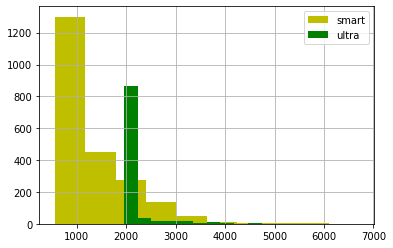

In [32]:
smart_final_cost = df.loc[df['tariff_name'] == 'smart', 'final_cost']
ultra_final_cost = df.loc[df['tariff_name'] == 'ultra', 'final_cost']

smart_final_cost.hist(color='y')
ultra_final_cost.hist(color='g')
plt.legend(legend)

Данные, как мы видим, распределены ассиметрично. Однако мы всё же собираемся применить для сравнения средних значений t-test, поскольку выборки независимые. Перед этим проверим равенство дисперсий.

In [33]:
print(np.var(smart_final_cost, ddof=1))
print(np.var(ultra_final_cost, ddof=1))

620363.2836462253
128164.2326343091


Дисперсии различаются. Проводим t-test.

In [34]:
alpha = 0.05

results = st.ttest_ind(
    smart_final_cost,
    ultra_final_cost,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.625902068022238e-294
Отвергаем нулевую гипотезу


То есть гипотеза о том, что средние выручки от пользователей тарифов smart и ultra равны, отвергается.

Во-вторых, нам нужно проверить гипотезу о различии средней выручки от пользователей из Москвы от выручки от пользователей из других регионов. Сформулируем наши гипотезы следующим образом:
* **H0: средние выручки абонентов из Москвы и абонентов из других регионов равны**
* **H1: средние выручки абонентов из Москвы и абонентов из других регионов отличаются**

Проверим равенство дисперсий и посмотрим на распределение.

In [35]:
moscow = df.loc[df['city'] == 'Москва', 'final_cost']
regions = df.loc[df['city'] != 'Москва', 'final_cost']



print(np.var(moscow, ddof=1))
print(np.var(regions, ddof=1))

547132.6987684795
631962.7551676158


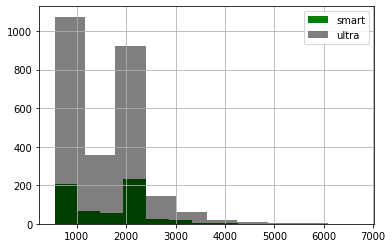

In [36]:
moscow.hist(color='g')
regions.hist(color='k', alpha=0.5)
plt.legend(legend)

Дисперсии разные. Проводим t-test.

In [37]:
results = st.ttest_ind(
    moscow,
    regions,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.432654128740637
Не получилось отвергнуть нулевую гипотезу


Вероятнее всего, средняя выручка от абонентов из Москвы и регионов почти не отличается.

In [38]:
#Посмотрим на средние показатели выборки.
print(moscow.mean())
print(regions.mean())

1507.0671031096563
1480.5691119691119


Средние выручки по нашей выборке действительно близки.

### Вывод

Мы выдвинули две гипотезы. Гипотеза о том, что выручки от абонентов обоих тарифов равны, в результате была отвергнута. То есть верна, скорее, альтернативная гипотеза: выручки от пользователей тарифов smart и ultra отличаются.

Гипотезу о том, что выручки от абонентов из Москвы и других регионов равны, не получилось отвергнуть.

### Общий вывод

Главный вывод заключается в том, что, судя по результатам предварительного анализа небольшой выборки, больше денег компании "Мегалайн" приносят пользователи тарифа ULTRA. Они заметно активнее используют минуты, мегабайты и СМС.

* **Пользователь тарифа SMART в среднем тратит 1234 рубля**. Пользователям тарифа SMART обычно не хватает предложенного в тарифе пакета интернет-трафика и им приходится доплачивать за дополнительные гигабайты.
* **Пользователь тарифа ULTRA в среднем тратит 2062 рубля**. Это на 112 рублей больше месячной стоимости тарифа.

Особенность представленных для анализа данных состоит в том, что число пользователей в них растет с каждым месяцем. Меньшая активность пользователей в использовании пакета услуг в начале года может быть связана с тем, что выборка в первые месяцы менее репрезентативна, чем в более поздние месяцы.

Активность пользователей выглядит так:

**Сколько минут нужно пользователю в месяц** (медиана):
* SMART: 440 (в тариф включено 500)
* ULTRA: 537 (в тариф включено 3000)


**Сколько мегабайт нужно пользователю в месяц** (медиана): 
* SMART: 16985 (в тариф включено 15360)
* ULTRA: 19826 (в тариф включено 30720)

**Сколько сообщений отправляют пользователи в месяц** (медиана):
* SMART: 28 (в тариф включено 50)
* ULTRA: 48 (в тариф включено 1000)

Наши расчеты подтвердил и статистический t-test. Мы отвергли гипотезу о том, что средние выручки от пользователей тарифов smart и ultra равны.

Гипотезу о равенстве выручек от пользователей из Москвы и других регионов России отвергнуть в результате t-теста не удалось. По нашим расчетам на данных из выборки разница между средними выручками этих категорий пользователей составляет не больше 30 рублей или 1,8%.


